In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely import wkt
import networkx as nx
import dill
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import ast
import utils_pre_processing as upp
from utils_pre_processing import split_col_to_and_from
# Show all columns when using .head()
pd.set_option('display.max_columns', None)

In [5]:
iggielgn_borderpoints = pd.read_csv('IGGIELGN/IGGIELGN_BorderPoints.csv', delimiter=';')
iggielgn_compressors = pd.read_csv('IGGIELGN/IGGIELGN_Compressors.csv', delimiter=';')
iggielgn_consumers = pd.read_csv('IGGIELGN/IGGIELGN_Consumers.csv', delimiter=';')
iggielgn_lngs = pd.read_csv('IGGIELGN/IGGIELGN_LNGs.csv', delimiter=';')
iggielgn_nodes = pd.read_csv('IGGIELGN/IGGIELGN_Nodes.csv', delimiter=';')
iggielgn_pipesegments = pd.read_csv('IGGIELGN/IGGIELGN_PipeSegments.csv', delimiter=';')
iggielgn_productions = pd.read_csv('IGGIELGN/IGGIELGN_Productions.csv', delimiter=';')
iggielgn_storages = pd.read_csv('IGGIELGN/IGGIELGN_Storages.csv', delimiter=';')

In [7]:
# Print the number of entries in each table
print('BorderPoints:', len(iggielgn_borderpoints))
print('Compressors:', len(iggielgn_compressors))
print('Consumers:', len(iggielgn_consumers))
print('LNGs:', len(iggielgn_lngs))
print('Nodes:', len(iggielgn_nodes))
print('PipeSegments:', len(iggielgn_pipesegments))
print('Productions:', len(iggielgn_productions))
print('Storages:', len(iggielgn_storages))

BorderPoints: 109
Compressors: 246
Consumers: 527
LNGs: 30
Nodes: 4675
PipeSegments: 6323
Productions: 106
Storages: 270


In [8]:
iggielgn_borderpoints = upp.split_column_to_multiple(iggielgn_borderpoints, 'method', 'method_')
iggielgn_compressors = upp.split_column_to_multiple(iggielgn_compressors, 'method', 'method_')
iggielgn_consumers = upp.split_column_to_multiple(iggielgn_consumers, 'method', 'method_')
iggielgn_lngs = upp.split_column_to_multiple(iggielgn_lngs, 'method', 'method_')
iggielgn_nodes = upp.split_column_to_multiple(iggielgn_nodes, 'method', 'method_')
iggielgn_pipesegments = upp.split_column_to_multiple(iggielgn_pipesegments, 'method', 'method_')
iggielgn_productions = upp.split_column_to_multiple(iggielgn_productions, 'method', 'method_')
iggielgn_storages = upp.split_column_to_multiple(iggielgn_storages, 'method', 'method_')

In [9]:
def data_density(df, component_name, plot_graphs=False):

    # Get the columns starting with method_
    method_cols = [col for col in df.columns if col.startswith('method_')]

    # For each column, count the number of rows where the value is 'raw', and the number of rows where the value is not 'raw'
    method_counts = {}
    for col in method_cols:
        # Count the number of rows where the value is 'raw'
        raw_count = df[df[col] == 'raw'][col].count()
        # Count the number of rows where the value is not 'raw', as the number of rows minus the number of 'raw' rows. If the value is None, it is not 'raw'
        non_raw_count = df[col].count() - raw_count
        # Add None values to the non_raw_count if there are any
        if df[col].isnull().sum() > 0:
            non_raw_count += df[col].isnull().sum()
        # Store the counts in a dataframe
        method_counts[col] = {'raw': raw_count, 'non_raw': non_raw_count}
        method_counts_df = pd.DataFrame(method_counts).T

    if plot_graphs:
        method_counts_df.plot(kind='bar', stacked=True)
        plt.legend(['Raw', 'Non-raw'], loc='upper left')
        plt.title(f'Data density for {component_name}')

    return method_counts_df

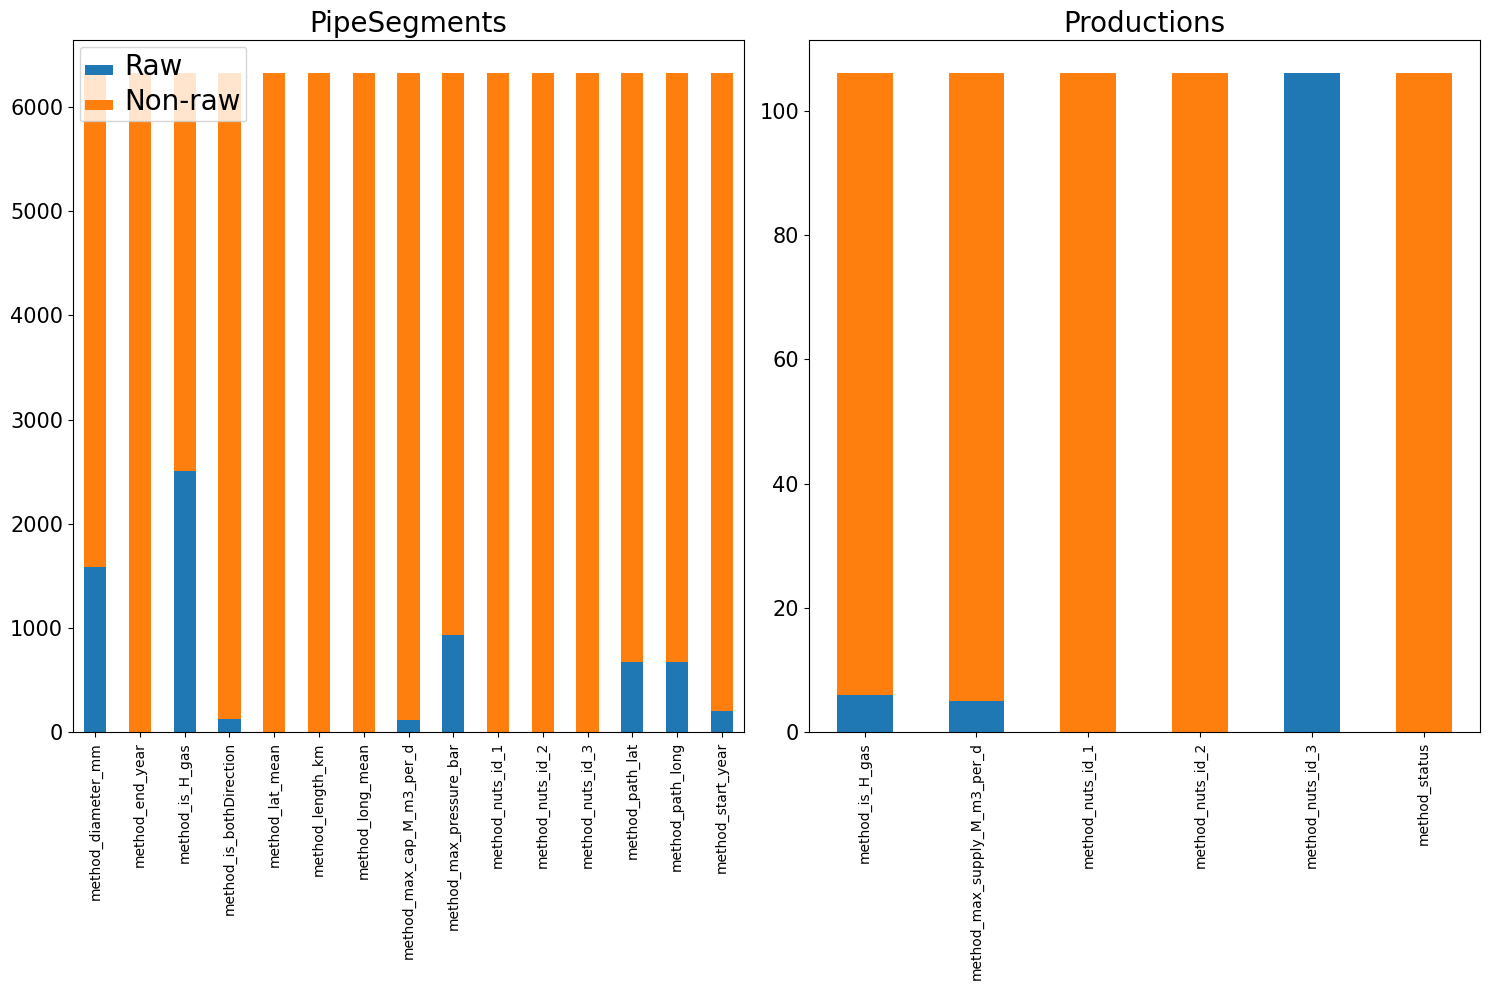

In [44]:
# Create a 1x2 grid of subplots, PipeSegments and Productions data density
iggielgn_pipesegments_density = data_density(iggielgn_pipesegments, 'PipeSegments')
iggielgn_productions_density = data_density(iggielgn_productions, 'Productions')

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
iggielgn_pipesegments_density.plot(kind='bar', stacked=True, ax=axs[0])
iggielgn_productions_density.plot(kind='bar', stacked=True, ax=axs[1])
axs[0].set_title('PipeSegments', fontsize=20)
axs[1].set_title('Productions', fontsize=20)
axs[0].legend(['Raw', 'Non-raw'], loc='upper left')
# Hide the second legend
axs[1].legend().set_visible(False)
# Set fontsize of all text on the plot to 20
plt.setp(axs[0].get_yticklabels(), fontsize=15)
plt.setp(axs[1].get_yticklabels(), fontsize=15)
plt.setp(axs[0].get_legend().get_texts(), fontsize=20)

# Save the figure, but make sure the labels are not cut off
plt.tight_layout()
plt.savefig('latex_figures/data_density.png')


plt.show()

In [11]:
# Calculate the percentage of raw data for each component, in total, across all columns
iggielgn_pipesegments_raw_percentage = iggielgn_pipesegments_density['raw'].sum() / (iggielgn_pipesegments_density['raw'].sum() + iggielgn_pipesegments_density['non_raw'].sum()) * 100
iggielgn_productions_raw_percentage = iggielgn_productions_density['raw'].sum() / (iggielgn_productions_density['raw'].sum() + iggielgn_productions_density['non_raw'].sum()) * 100
iggielgn_consumers_raw_percentage = iggielgn_consumers_density['raw'].sum() / (iggielgn_consumers_density['raw'].sum() + iggielgn_consumers_density['non_raw'].sum()) * 100
iggielgn_storages_raw_percentage = iggielgn_storages_density['raw'].sum() / (iggielgn_storages_density['raw'].sum() + iggielgn_storages_density['non_raw'].sum()) * 100

print(f'PipeSegments raw data percentage: {iggielgn_pipesegments_raw_percentage:.2f}%')
print(f'Productions raw data percentage: {iggielgn_productions_raw_percentage:.2f}%')
print(f'Consumers raw data percentage: {iggielgn_consumers_raw_percentage:.2f}%')
print(f'Storages raw data percentage: {iggielgn_storages_raw_percentage:.2f}%')

PipeSegments raw data percentage: 7.19%
Productions raw data percentage: 18.40%
Consumers raw data percentage: 53.46%
Storages raw data percentage: 38.36%


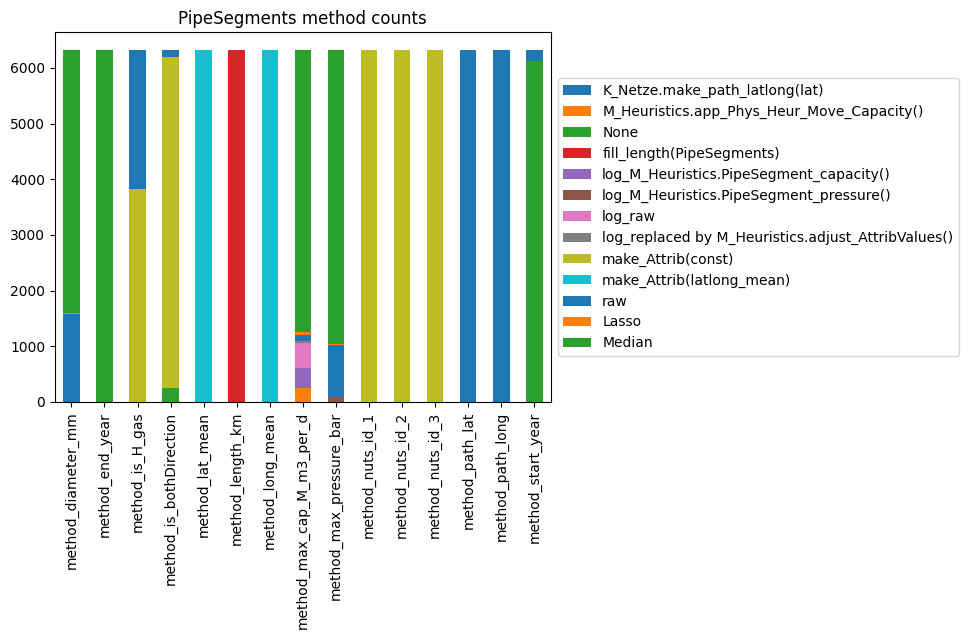

In [12]:
# For each component, create a new dataframe containing the count of values in the method_ columns

# Filter in the method_ columns
iggielgn_pipesegments_methods = iggielgn_pipesegments.filter(like='method_')

# Fill the None values with "None"
iggielgn_pipesegments_methods = iggielgn_pipesegments_methods.fillna('None')

# Create a new dataframe containing the count of values in the method_ columns
iggielgn_pipesegments_methods_counts = iggielgn_pipesegments_methods.apply(lambda x: x.value_counts()).T

# Combine the counts of all columns starting with Lasso( into a single column, and drop the original columns
iggielgn_pipesegments_methods_counts['Lasso'] = iggielgn_pipesegments_methods_counts.filter(like='Lasso(').sum(axis=1)
iggielgn_pipesegments_methods_counts.drop(iggielgn_pipesegments_methods_counts.filter(like='Lasso(').columns, axis=1, inplace=True)

# Combine the counts of all columns starting with Median( into a single column, and drop the original columns
iggielgn_pipesegments_methods_counts['Median'] = iggielgn_pipesegments_methods_counts.filter(like='Median(').sum(axis=1)
iggielgn_pipesegments_methods_counts.drop(iggielgn_pipesegments_methods_counts.filter(like='Median(').columns, axis=1, inplace=True)

# Count makeAttrib(laglong_mean) as raw
# iggielgn_pipesegments_methods_counts['raw'] = iggielgn_pipesegments_methods_counts['raw'] + iggielgn_pipesegments_methods_counts['make_Attrib(latlong_mean)']

# Plot the count of values in the method_ columns for PipeSegments as a stacked bar chart
iggielgn_pipesegments_methods_counts.plot(kind='bar', stacked=True)
plt.title('PipeSegments method counts')
# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

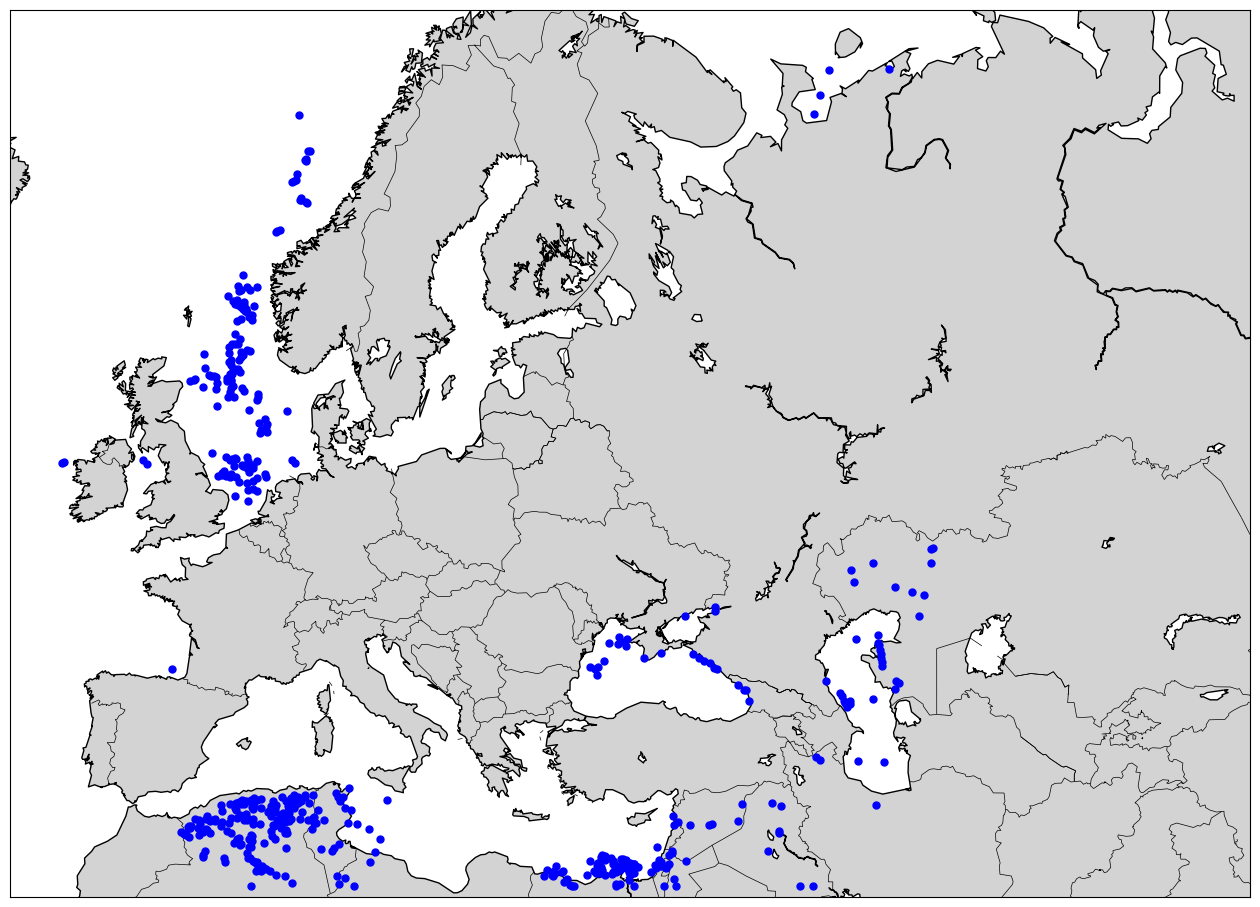

In [22]:
# On a map of Europe, plot the nodes with country_code = XX
# Filter the nodes where country_code = XX
iggielgn_nodes_xx = iggielgn_nodes[iggielgn_nodes['country_code'] == 'XX']

fig, ax = plt.subplots(figsize=(16, 16))

# Use BaseMap to underlay a map of Europe
m = Basemap(projection='merc', llcrnrlat=30, urcrnrlat=70, llcrnrlon=-15, urcrnrlon=80, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray')

# Plot the nodes on the map
for row in iggielgn_nodes_xx.itertuples():
    x, y = m(row.long, row.lat)
    m.plot(x, y, 'bo', markersize=5)

# Save the plot, without whitespace above and below the plot
plt.savefig('latex_figures/iggielgn_nodes_xx.png', bbox_inches='tight')

plt.show()